## Generate Power-Grid

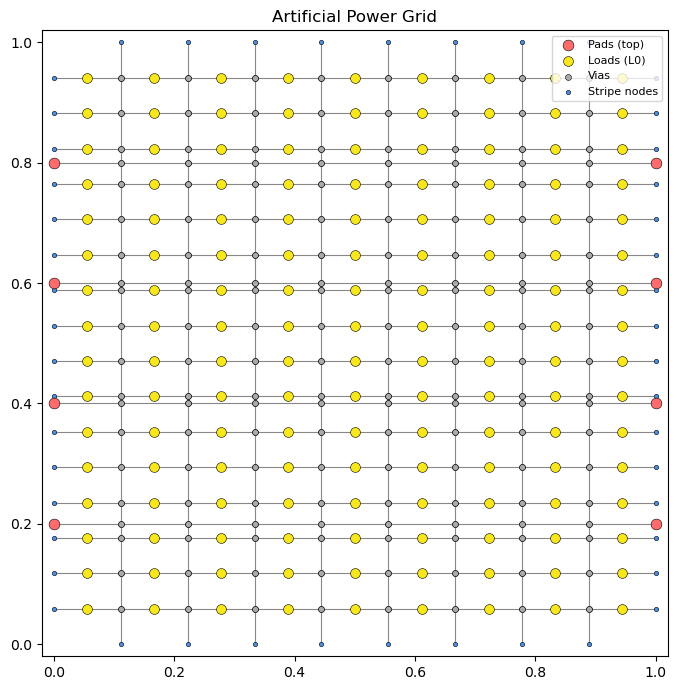

Graph: 520 nodes, 652 edges
Loads placed: 144 nodes; Pads: 8


In [1]:
from generate_power_grid import generate_power_grid

G, loads, pads = generate_power_grid(
    K=3,
    N0=16,
    I_N=1000,
    N_vsrc=8,
    max_stripe_res=5.0,   # Ω per stripe in layer 0
    max_via_res=0.1,      # Ω for vias between L0-L1; halves on higher vias
    load_current=1.0,
    seed=7,
    plot=True,
)
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loads placed: {len(loads)} nodes; Pads: {len(pads)}")

In [2]:
from irdrop import PowerGridModel, StimulusGenerator, IRDropSolver

# Build model (pads at 1.0V)
model = PowerGridModel(G, pad_nodes=pads, vdd=1.0)

/home/patrasej/workspace_dev2/local/miniconda3/envs/pyspice/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:573: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format',


In [3]:
# Stimulus generator using discovered load nodes
stim_gen = StimulusGenerator(load_nodes=list(loads.keys()), vdd=1.0, seed=7, graph=G)

In [4]:
stimulus_area = (0.4, 0.4, 0.6, 0.6)
x1,y1,x2,y2 = stimulus_area
inside = []
for n in loads:
    x,y = G.nodes[n]['xy']
    if x1 <= x <= x2 and y1 <= y <= y2:
        inside.append((n,x,y))
inside, len(inside)

([(NodeID(layer=0, idx=218), 0.5, 0.4117647058823529),
  (NodeID(layer=0, idx=227), 0.5, 0.47058823529411764),
  (NodeID(layer=0, idx=236), 0.5, 0.5294117647058824),
  (NodeID(layer=0, idx=245), 0.5, 0.5882352941176471)],
 4)

In [5]:
#meta = stim_gen.generate(1., count=4, distribution="gaussian", gaussian_loc=1.0, gaussian_scale=0.2, area=stimulus_area)
meta = stim_gen.generate(1., percent=0.1, distribution="gaussian", gaussian_loc=1.0, gaussian_scale=0.2)
solver = IRDropSolver(model)
result = solver.solve(meta.currents, meta)

In [6]:
current_nodes = [n for n in meta.currents.keys()]
current_nodes

[NodeID(layer=0, idx=242),
 NodeID(layer=0, idx=198),
 NodeID(layer=0, idx=261),
 NodeID(layer=0, idx=172),
 NodeID(layer=0, idx=178),
 NodeID(layer=0, idx=297),
 NodeID(layer=0, idx=184),
 NodeID(layer=0, idx=253),
 NodeID(layer=0, idx=174),
 NodeID(layer=0, idx=289),
 NodeID(layer=0, idx=214),
 NodeID(layer=0, idx=169),
 NodeID(layer=0, idx=182),
 NodeID(layer=0, idx=271)]

In [7]:
meta.currents

{NodeID(layer=0, idx=242): 0.06867812793910091,
 NodeID(layer=0, idx=198): 0.05749748010360251,
 NodeID(layer=0, idx=261): 0.07045412118951701,
 NodeID(layer=0, idx=172): 0.08175584640744475,
 NodeID(layer=0, idx=178): 0.06678397731984301,
 NodeID(layer=0, idx=297): 0.08889861725236521,
 NodeID(layer=0, idx=184): 0.06564417132744242,
 NodeID(layer=0, idx=253): 0.08351202415414706,
 NodeID(layer=0, idx=174): 0.06942674197303872,
 NodeID(layer=0, idx=289): 0.06746681139830359,
 NodeID(layer=0, idx=214): 0.0781288436202606,
 NodeID(layer=0, idx=169): 0.08281154719371286,
 NodeID(layer=0, idx=182): 0.048064709731545696,
 NodeID(layer=0, idx=271): 0.07087698038967574}

In [8]:
# Show ir-drop at meta.currents nodes
[1.0 - result.voltages[n] for n in meta.currents.keys()]

[0.04418241775445275,
 0.047276485668495294,
 0.050639482075377495,
 0.06518093835930949,
 0.06932106609245914,
 0.06176969114505737,
 0.049131089251322924,
 0.053058444249660885,
 0.0585532270835456,
 0.05563274485159975,
 0.06055449546463454,
 0.08193992719464738,
 0.055037738430696814,
 0.05227740902298095]

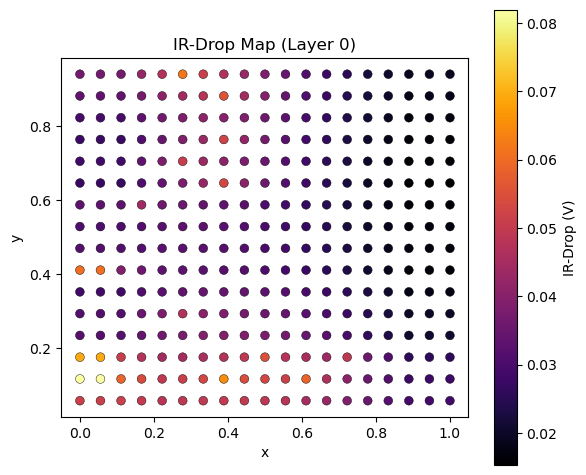

In [9]:
from IPython.display import display
from irdrop import plot_ir_drop_map
# Corrected call: pass vdd as numeric (1.0) and optionally layer=0
fig, ax = plot_ir_drop_map(G, result.voltages, vdd=1.0, layer=0)
display(fig)

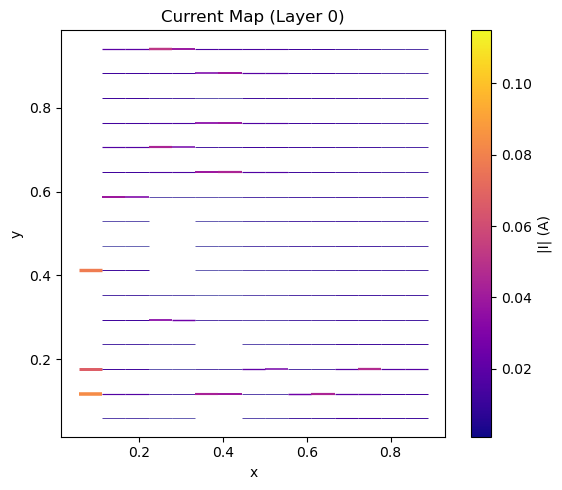

In [ ]:
from irdrop import plot_current_map
fig, ax = plot_current_map(G, result.voltages, layer=0, min_current=1.e-2, loads_current=meta.currents, show=False)
display(fig)

## Effective Resistance Computation

Compute effective resistance between node pairs using the `EffectiveResistanceCalculator`.

In [25]:
from irdrop import EffectiveResistanceCalculator
import numpy as np

# Create calculator using the existing model
calc = EffectiveResistanceCalculator(model)

# Get some load nodes to test
load_nodes = current_nodes + list(loads.keys())[:10]
print(f"Testing with {len(load_nodes)} load nodes")

Testing with 11 load nodes


In [26]:
# Example 1: Compute R_eff from nodes to ground (pads)
ground_pairs = [(node, None) for node in load_nodes]
reff_to_ground = calc.compute_batch(ground_pairs)

print("Effective resistance to ground (first 5):")
for i in range(5):
    print(f"  {load_nodes[i]}: {reff_to_ground[i]:.6f} Ω")
    
print(f"\nStatistics:")
print(f"  Min: {np.min(reff_to_ground):.6f} Ω")
print(f"  Max: {np.max(reff_to_ground):.6f} Ω")
print(f"  Mean: {np.mean(reff_to_ground):.6f} Ω")

Effective resistance to ground (first 5):
  NodeID(layer=0, idx=236): 0.279355 Ω
  NodeID(layer=0, idx=160): 0.637724 Ω
  NodeID(layer=0, idx=161): 0.392620 Ω
  NodeID(layer=0, idx=162): 0.362060 Ω
  NodeID(layer=0, idx=163): 0.358665 Ω

Statistics:
  Min: 0.279355 Ω
  Max: 0.637724 Ω
  Mean: 0.428787 Ω


In [28]:
# Example 2: Compute R_eff between pairs of nodes
node_pairs = [(load_nodes[i], load_nodes[i+1]) for i in range(5)]
reff_pairs = calc.compute_batch(node_pairs)

print("Effective resistance between node pairs:")
for i, (u, v) in enumerate(node_pairs):
    print(f"  {u} ↔ {v}: {reff_pairs[i]:.6f} Ω")

Effective resistance between node pairs:
  NodeID(layer=0, idx=236) ↔ NodeID(layer=0, idx=160): 0.875586 Ω
  NodeID(layer=0, idx=160) ↔ NodeID(layer=0, idx=161): 0.490964 Ω
  NodeID(layer=0, idx=161) ↔ NodeID(layer=0, idx=162): 0.385666 Ω
  NodeID(layer=0, idx=162) ↔ NodeID(layer=0, idx=163): 0.375264 Ω
  NodeID(layer=0, idx=163) ↔ NodeID(layer=0, idx=164): 0.373643 Ω


In [29]:
# Example 3: Mixed batch - combine ground and node-to-node pairs
mixed_pairs = [
    (load_nodes[0], None),           # to ground
    (load_nodes[1], load_nodes[2]),  # node-to-node
    (load_nodes[3], None),           # to ground
    (load_nodes[4], load_nodes[5]),  # node-to-node
]
reff_mixed = calc.compute_batch(mixed_pairs)

print("Mixed batch results:")
for i, (u, v) in enumerate(mixed_pairs):
    if v is None:
        print(f"  {u} → ground: {reff_mixed[i]:.6f} Ω")
    else:
        print(f"  {u} ↔ {v}: {reff_mixed[i]:.6f} Ω")

Mixed batch results:
  NodeID(layer=0, idx=236) → ground: 0.279355 Ω
  NodeID(layer=0, idx=160) ↔ NodeID(layer=0, idx=161): 0.490964 Ω
  NodeID(layer=0, idx=162) → ground: 0.362060 Ω
  NodeID(layer=0, idx=163) ↔ NodeID(layer=0, idx=164): 0.373643 Ω


## Grid Partitioning

Partition the power grid into spatial regions using the `GridPartitioner`. The partitioner uses k-means clustering on node geometries to create balanced partitions with separator nodes on boundaries.

In [ ]:
from irdrop import GridPartitioner

# Create a fresh grid for partitioning (since partitioning modifies the graph)
G_part, loads_part, pads_part = generate_power_grid(
    K=3,
    N0=16,
    I_N=100,
    N_vsrc=8,
    max_stripe_res=5.0,
    max_via_res=0.1,
    load_current=1.0,
    seed=7,
    plot=False,
)

print(f"Grid for partitioning: {G_part.number_of_nodes()} nodes, {G_part.number_of_edges()} edges")
print(f"Loads: {len(loads_part)}, Pads: {len(pads_part)}")

In [ ]:
# Partition the grid into 4 spatial regions
partitioner = GridPartitioner(G_part, loads_part, pads_part, seed=42)
part_result = partitioner.partition(P=4, balance_tolerance=0.15)

print(part_result)
print("\nPartition details:")
for partition in part_result.partitions:
    print(f"  Partition {partition.partition_id}: "
          f"{partition.num_loads} loads, "
          f"{len(partition.separator_nodes)} separators, "
          f"{len(partition.interior_nodes)} interior nodes")

In [ ]:
# Visualize the partitioned grid
fig, ax = partitioner.visualize_partitions(part_result, figsize=(12, 10), show=False)
display(fig)

In [ ]:
# Verify partitioning properties
print("Partitioning Verification:")
print(f"  Total loads in original grid: {len(loads_part)}")
print(f"  Total loads across partitions: {sum(p.num_loads for p in part_result.partitions)}")
print(f"  Total separator nodes: {len(part_result.separator_nodes)}")
print(f"  Total removed edges: {len(part_result.removed_edges)}")
print(f"  Load balance ratio: {part_result.load_balance_ratio:.3f}")

# Check no inter-partition edges remain
node_to_partition = {}
for partition in part_result.partitions:
    for node in partition.all_nodes:
        node_to_partition[node] = partition.partition_id

inter_partition_edges = 0
for u, v in G_part.edges():
    if u in pads_part or v in pads_part:
        continue
    if u in node_to_partition and v in node_to_partition:
        if node_to_partition[u] != node_to_partition[v]:
            inter_partition_edges += 1

print(f"\nInter-partition edges remaining: {inter_partition_edges} (should be 0)")

In [ ]:
# Example: Partition with different P values
print("Partitioning with different P values:\n")
for P in [2, 3, 4, 6]:
    # Create fresh grid for each test
    G_test, loads_test, pads_test = generate_power_grid(
        K=3, N0=16, I_N=100, N_vsrc=8,
        max_stripe_res=5.0, max_via_res=0.1,
        load_current=1.0, seed=7, plot=False
    )
    
    partitioner_test = GridPartitioner(G_test, loads_test, pads_test, seed=42)
    result_test = partitioner_test.partition(P=P, balance_tolerance=0.15)
    
    load_counts = [p.num_loads for p in result_test.partitions]
    print(f"P={P}: loads={load_counts}, balance_ratio={result_test.load_balance_ratio:.3f}, "
          f"removed_edges={len(result_test.removed_edges)}")

## Regional IR-Drop Solver

Test the `RegionalIRDropSolver` which computes IR-drops at a subset of load nodes within a partitioned region using effective resistance and boundary conditions.

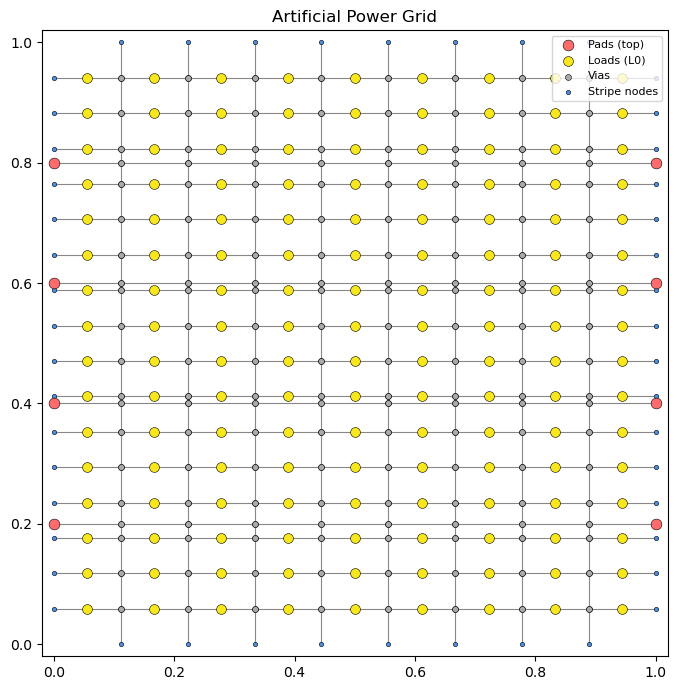

Regional solver test grid: 520 nodes, 652 edges
Loads: 144, Pads: 8


In [1]:
import numpy as np
from generate_power_grid import generate_power_grid


# Create a fresh grid for regional solver testing
G_regional, loads_regional, pads_regional = generate_power_grid(
    K=3,
    N0=16,
    I_N=1000,
    N_vsrc=8,
    max_stripe_res=5.0,   # Ω per stripe in layer 0
    max_via_res=0.1,      # Ω for vias between L0-L1; halves on higher vias
    load_current=0.01,
    seed=7,
    plot=True,
)

print(f"Regional solver test grid: {G_regional.number_of_nodes()} nodes, {G_regional.number_of_edges()} edges")
print(f"Loads: {len(loads_regional)}, Pads: {len(pads_regional)}")

In [2]:
from irdrop import PowerGridModel, StimulusGenerator, IRDropSolver, RegionalIRDropSolver, GridPartitioner, EffectiveResistanceCalculator

# Build model and calculator
model_regional = PowerGridModel(G_regional, pad_nodes=pads_regional, vdd=1.0)
calc_regional = EffectiveResistanceCalculator(model_regional)

/home/patrasej/workspace_dev2/local/miniconda3/envs/pyspice/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:573: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format',


In [3]:
# Partition the grid into 4 regions
partitioner_regional = GridPartitioner(G_regional, loads_regional, pads_regional, seed=42)
part_result_regional = partitioner_regional.partition(P=3, axis='x')

print(f"Created {part_result_regional.num_partitions} partitions")
print(f"Load balance ratio: {part_result_regional.load_balance_ratio:.2f}")

# Select first partition for testing
partition = part_result_regional.partitions[0]
print(f"\nPartition {partition.partition_id}:")
print(f"  Interior nodes: {len(partition.interior_nodes)}")
print(f"  Separator nodes: {len(partition.separator_nodes)}")
print(f"  Load nodes: {len(partition.load_nodes)}")

Created 3 partitions
Load balance ratio: 1.00

Partition 0:
  Interior nodes: 148
  Separator nodes: 33
  Load nodes: 48


In [4]:
# Stimulus generator using discovered load nodes
stim_gen = StimulusGenerator(load_nodes=list(loads_regional.keys()), vdd=1.0, seed=7, graph=G_regional)
meta = stim_gen.generate(1., percent=0.1, distribution="gaussian", gaussian_loc=1.0, gaussian_scale=0.2)

In [5]:
meta.currents

{NodeID(layer=0, idx=242): 0.09015063591011836,
 NodeID(layer=0, idx=198): 0.0670757654955892,
 NodeID(layer=0, idx=261): 0.04759469843022726,
 NodeID(layer=0, idx=172): 0.060936261096051964,
 NodeID(layer=0, idx=178): 0.0774635251597548,
 NodeID(layer=0, idx=297): 0.06300403091375249,
 NodeID(layer=0, idx=184): 0.09471493262487439,
 NodeID(layer=0, idx=253): 0.05780252708571341,
 NodeID(layer=0, idx=174): 0.08593697228935097,
 NodeID(layer=0, idx=289): 0.08467861049059909,
 NodeID(layer=0, idx=214): 0.06214685151889102,
 NodeID(layer=0, idx=169): 0.05442632428588754,
 NodeID(layer=0, idx=182): 0.07979151836208392,
 NodeID(layer=0, idx=271): 0.07427734633710538}

In [6]:
# Create regional solver
regional_solver = RegionalIRDropSolver(calc_regional)

# Define subset S (first 5 load nodes in the partition)
partition_loads = sorted(list(partition.load_nodes), key=lambda n: (n.layer, n.idx))
# randomly sample 5 nodes in the partition
S = set(np.random.choice(partition_loads, size=5, replace=False))

# Define region R and boundary A
R = partition.all_nodes
A = partition.separator_nodes

active_loads = meta.currents
# Define near loads (all loads in region R) and far loads (outside R)
loads_in_R = set(partition.load_nodes)
I_R = {node: active_loads[node] for node in loads_in_R if node in active_loads}
all_far_loads = set(active_loads.keys()) - loads_in_R
I_F = {node: active_loads[node] for node in all_far_loads}

print(f"Subset S: {len(S)} nodes")
print(f"Near loads (in R): {len(I_R)} nodes")
print(f"Far loads (outside R): {len(I_F)} nodes")
print(f"Boundary nodes (A): {len(A)} nodes")

Subset S: 5 nodes
Near loads (in R): 7 nodes
Far loads (outside R): 7 nodes
Boundary nodes (A): 33 nodes


In [8]:
# Compute IR-drops using regional solver
ir_drops_regional, drop_near, drop_far = regional_solver.compute_ir_drops(S, R, A, I_R, I_F)

print(f"Computed IR-drops for {len(ir_drops_regional)} nodes\n")
print("IR-drop results:")
for node in S:
    drop = ir_drops_regional[node]
    drop_n = drop_near[node]
    drop_f = drop_far[node]
    voltage = 1.0 - drop
    print(f"  {node}: IR-drop = {drop:.6f} V (near={drop_n:.6f}, far={drop_f:.6f}), Voltage = {voltage:.6f} V")

Computed IR-drops for 5 nodes

IR-drop results:
  NodeID(layer=0, idx=232): IR-drop = 0.030461 V (near=0.018953, far=0.011508), Voltage = 0.969539 V
  NodeID(layer=0, idx=180): IR-drop = 0.045933 V (near=0.021271, far=0.024662), Voltage = 0.954067 V
  NodeID(layer=0, idx=225): IR-drop = 0.032142 V (near=0.017122, far=0.015020), Voltage = 0.967858 V
  NodeID(layer=0, idx=170): IR-drop = 0.050673 V (near=0.029929, far=0.020743), Voltage = 0.949327 V
  NodeID(layer=0, idx=288): IR-drop = 0.041733 V (near=0.017551, far=0.024182), Voltage = 0.958267 V


### Validation: Compare Regional Solver vs Full Solver

Verify the regional solver accuracy by comparing against the full IR-drop solver.

In [9]:
# Run full solver for comparison
full_solver_regional = IRDropSolver(model_regional)
result_full_regional = full_solver_regional.solve(active_loads)

# Extract IR-drops for nodes in S
ir_drops_full = {node: result_full_regional.ir_drop[node] for node in S}

# Compare results
print("Comparison: Regional vs Full Solver\n")
print(f"{'Node':<20} {'Regional':<12} {'Full':<12} {'Error':<12} {'Near':<12} {'Far':<12}")
print("-" * 80)

errors = []
for node in S:
    drop_regional = ir_drops_regional[node]
    drop_full = ir_drops_full[node]
    error = abs(drop_regional - drop_full)
    errors.append(error)
    print(f"{str(node):<20} {drop_regional:<12.6f} {drop_full:<12.6f} {error:<12.2e} {drop_near[node]:<12.6f} {drop_far[node]:<12.6f}")

print(f"\nError Statistics:")
print(f"  Mean absolute error: {np.mean(errors):.2e} V")
print(f"  Max absolute error:  {np.max(errors):.2e} V")
print(f"  RMS error:           {np.sqrt(np.mean(np.array(errors)**2)):.2e} V")

Comparison: Regional vs Full Solver

Node                 Regional     Full         Error        Near         Far         
--------------------------------------------------------------------------------
NodeID(layer=0, idx=232) 0.030461     0.030461     6.93e-15     0.018953     0.011508    
NodeID(layer=0, idx=180) 0.045933     0.045933     9.04e-15     0.021271     0.024662    
NodeID(layer=0, idx=225) 0.032142     0.032142     8.34e-15     0.017122     0.015020    
NodeID(layer=0, idx=170) 0.050673     0.050673     8.65e-15     0.029929     0.020743    
NodeID(layer=0, idx=288) 0.041733     0.041733     7.55e-15     0.017551     0.024182    

Error Statistics:
  Mean absolute error: 8.10e-15 V
  Max absolute error:  9.04e-15 V
  RMS error:           8.14e-15 V


### Visualize Regional Solver Results

Visualize the partitioned grid with the computed IR-drops at subset S.

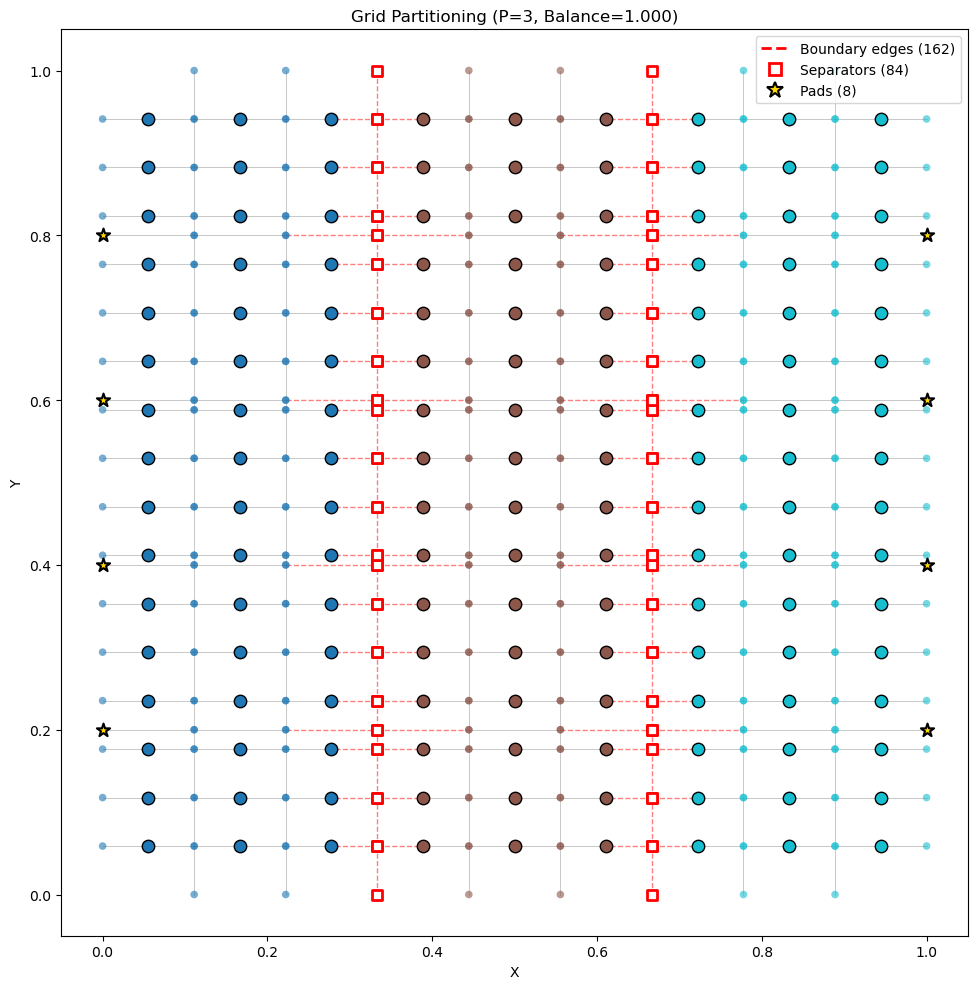

In [25]:
# Visualize the partitioned grid
fig_part, ax_part = partitioner_regional.visualize_partitions(part_result_regional, figsize=(12, 10), show=False)
display(fig_part)

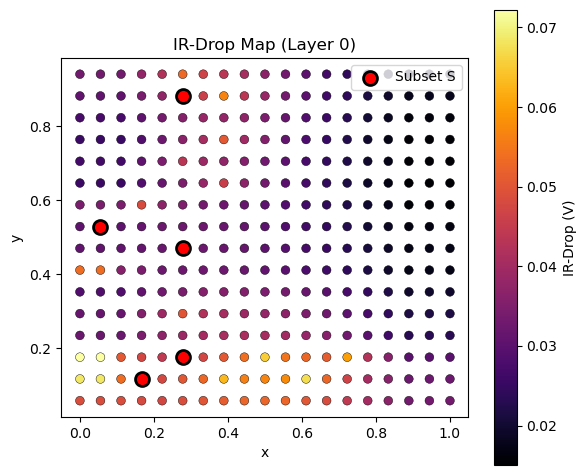

In [10]:
from IPython.display import display
from irdrop import plot_ir_drop_map

# Create a voltage map with regional solver results
# Build full voltage dictionary from regional results
voltages_regional_map = {}
for node in S:
    voltages_regional_map[node] = 1.0 - ir_drops_regional[node]

# Plot IR-drop map for layer 0 showing the subset S nodes
fig_irdrop, ax_irdrop = plot_ir_drop_map(G_regional, result_full_regional.voltages, vdd=1.0, layer=0)

# Highlight the subset S nodes
for node in S:
    if node.layer == 0:
        x, y = G_regional.nodes[node]['xy']
        ax_irdrop.scatter([x], [y], c='red', s=100, marker='o', edgecolors='black', linewidths=2, zorder=10, label='Subset S')

# Remove duplicate labels
handles, labels = ax_irdrop.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_irdrop.legend(by_label.values(), by_label.keys())

display(fig_irdrop)

### Visualize Current Map with Load Currents

Show the resistor currents with load current magnitudes overlaid as colored dots.

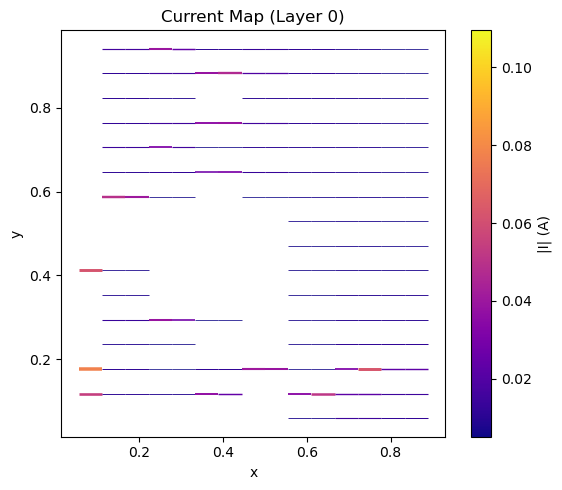

In [13]:
from irdrop import plot_current_map
fig, ax = plot_current_map(G_regional, result_full_regional.voltages, layer=0, min_current=5.e-3, show=True)
display(fig)

In [ ]:
# Plot current map with load currents for the regional solver test
fig_currents, ax_currents = plot_current_map(
    G_regional, 
    result_full_regional.voltages, 
    layer=0, 
    min_current=5e-4, 
    loads_current=loads_regional,
    show=False
)
display(fig_currents)